# Constants
Change these to fit your needs

In [1]:
# Are you developing locally or on google colab?
COLAB = True

# path kaggle will download to
HM_DATA_PATH = "/content/drive/MyDrive/dd2430/data/" if COLAB else "./data/"

# path tourch.save and .load will use
PTH_SAVE_PATH = "/content/drive/MyDrive/dd2430/pth/" if COLAB else "./pth/"

load_direct = True
if load_direct is True:
  HM_DATA_PATH, PTH_SAVE_PATH= '', '/content/'

# False if you have already downloaded once
DOWNLOAD_FROM_KAGGLE = False

# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = False

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 500

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [3]:
import os
import random
import numpy as np
from tqdm import tqdm
import importlib
import gdown
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import transformers
if COLAB:
    from google.colab import files, drive
    #!pip install git
    #!git clone https://[ADD PERSONAL ACCESS TOKEN]@github.com/Samin765/DD2430_Project.git
    !git clone https://github.com/Samin765/DD2430_Project.git

    #to pull down all files
    !mv -v /content/DD2430_Project/* /content/


Cloning into 'DD2430_Project'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 140 (delta 69), reused 54 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 4.51 MiB | 9.17 MiB/s, done.
Resolving deltas: 100% (69/69), done.
renamed '/content/DD2430_Project/CLIP on cat:dog dataset.ipynb' -> '/content/CLIP on cat:dog dataset.ipynb'
renamed '/content/DD2430_Project/CLIP_prompt.ipynb' -> '/content/CLIP_prompt.ipynb'
renamed '/content/DD2430_Project/create_dataset.py' -> '/content/create_dataset.py'
renamed '/content/DD2430_Project/Data_distrubution_histograms.ipynb' -> '/content/Data_distrubution_histograms.ipynb'
renamed '/content/DD2430_Project/datasets.py' -> '/content/datasets.py'
renamed '/content/DD2430_Project/extra_layer_fintune.ipynb' -> '/content/extra_layer_fintune.ipynb'
renamed '/content/DD2430_Project/Lora_CLIP_prompt.ipynb' -> '/content/Lora_CLIP_promp

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available(): # For apple silicon
    device = 'mps'

print("Using device: ", device)

Using device:  cuda


# Download data

In [ ]:
if DOWNLOAD_FROM_KAGGLE:
    !pip install kaggle
    files.upload()

    os.makedirs('/root/.kaggle', exist_ok=True)
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    %cd HM_DATA_PATH

    !kaggle competitions download -c h-and-m-personalized-fashion-recommendations


In [ ]:
if DOWNLOAD_FROM_KAGGLE:
    !unzip -q h-and-m-personalized-fashion-recommendations.zip

#Dataset

## Create new dataset
This will create a new dataset and save it as a .pth to google drive. If you getan error, then it is most likely becuase you can not make a daatset that large.

In [ ]:
import datasets
importlib.reload(datasets)

if CREATE_NEW_DATASET:
    dataset = datasets.HMDataset2(
        articles_csv = HM_DATA_PATH + 'articles.csv',
        image_dir = HM_DATA_PATH + 'images',
        main_class = 'garment_group_name',
        model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device),
        processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    )
    # data per class
    n_samples =  N_SAMPLES

    assert dataset.articles[dataset.main_class].value_counts().min()>n_samples, 'Can not make balanced set'

    # you can also set all to n_samples then set the ones you want to 0
    for exclude_subclass in ['Unknown', 'Special Offers', 'some other']:
        dataset.counts[exclude_subclass]=n_samples

    # Create uniform dataset
    image_emb, labels, images = dataset.get_n_of_each(n_samples)

    data_to_save = {
        'image_embedding': image_emb,
        'class_text': labels,
        'images': images,
    }
    os.makedirs(PTH_SAVE_PATH, exist_ok=True)
    torch.save(data_to_save, f'{PTH_SAVE_PATH}HM_data_{n_samples}.pth')

In [ ]:
def save_to_drive(data, n_samples):
    """Save the dataset you created to drive"""
    from google.colab import drive
    drive.mount('/content/drive')
    torch.save(data, f'/content/drive/My Drive/Skola/HM_data_{n_samples}.pth')
save_to_drive(data_to_save, N_SAMPLES)

Mounted at /content/drive


## Load dataset
If you already have the HM data and .pth saved in google drive, this is where the actual code/program begins.

Remember to change the constants at the top so you don't download and/or create a new dataset next time.

In [5]:
def load_from_private_drive():
    """If you have it locally"""
    #drive.mount('/content/drive')
    n_samples = N_SAMPLES
    file_to_load = f"HM_data_{n_samples}.pth"

    loaded_data = torch.load(f'/content/drive/MyDrive/Skola/{file_to_load}')

    image_emb = loaded_data['image_embedding']
    labels = loaded_data['class_text']
    images = loaded_data['images']

    #dataset = UniformHMDataset(image_emb, labels , images)
    return image_emb, images, labels

def load_from_project_drive(link):
    """Shared file in drive and insert link id"""
    import gdown
    output = 'Dataset_loaded.pth'
    gdown.download(f"https://drive.google.com/uc?id={link}", output, quiet=False)
    loaded_data = torch.load(output, map_location=device)
    image_emb = loaded_data['image_embedding']
    labels = loaded_data['class_text']
    images = loaded_data['images'] # good to have to see sclaling and transform..
    #dataset = UniformHMDataset(image_emb, labels , images)
    return image_emb, images, labels

project_drive = False # if you want to load from my drive, NEW SET
if project_drive:# DO NOT USE TOO OFTEN OR 24h waiting period
  data = load_from_project_drive(link='16we5aQ_Mbk1791_8WT522HmR0lwlwwqQ')
else:
  data = load_from_private_drive()
image_emb0, images0, labels0 = data

<ipython-input-5-8a7fac710fc7>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(f'/content/drive/MyDrive/Skola/{file_to_load}')


# Evaluate

**Pulls latest changes from Github if needed**

In [13]:
%cd DD2430_Project
!git pull https://github.com/Samin765/DD2430_Project.git
!mv -v /content/DD2430_Project/* /content/

[Errno 2] No such file or directory: 'DD2430_Project'
/content/DD2430_Project
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 3), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 2.33 KiB | 2.33 MiB/s, done.
From https://github.com/Samin765/DD2430_Project
 * branch            HEAD       -> FETCH_HEAD
Updating 5339d3c..96bb3a1
Fast-forward
 Lora_CLIP_prompt.ipynb | 5854 --------------------------------------------------------------------
 training.py            |  323 ++--
 2 files changed, 166 insertions(+), 6011 deletions(-)
 delete mode 100644 Lora_CLIP_prompt.ipynb
renamed '/content/DD2430_Project/training.py' -> '/content/training.py'


In [14]:
# functions for clip text and image embeddings, forward pass etc
# remember to import this again if you change something
# And varius function that doesn't fit into model_functions or datasets
# for example displaying images
import model_functions, utils, training, datasets
importlib.reload(utils) # issues with colab not updating
importlib.reload(training)
importlib.reload(model_functions)
importlib.reload(datasets)
import model_functions, utils, training

**Split datasets**

In [7]:
dataset, dataset_train, dataset_test, dataset_val = datasets.split(labels0, image_emb0, images0, N_SAMPLES, SET_SIZES)
batch_size = 200
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

9500 7600 950 950
Counter({'Accessories': 500, 'Blouses': 500, 'Dressed': 500, 'Dresses Ladies': 500, 'Dresses/Skirts girls': 500, 'Jersey Basic': 500, 'Jersey Fancy': 500, 'Knitwear': 500, 'Outdoor': 500, 'Shirts': 500, 'Shoes': 500, 'Shorts': 500, 'Skirts': 500, 'Socks and Tights': 500, 'Swimwear': 500, 'Trousers': 500, 'Trousers Denim': 500, 'Under-, Nightwear': 500, 'Woven/Jersey/Knitted mix Baby': 500})
Counter({'Shirts': 400, 'Jersey Fancy': 400, 'Shoes': 400, 'Trousers': 400, 'Trousers Denim': 400, 'Accessories': 400, 'Outdoor': 400, 'Dresses/Skirts girls': 400, 'Socks and Tights': 400, 'Shorts': 400, 'Blouses': 400, 'Dressed': 400, 'Knitwear': 400, 'Woven/Jersey/Knitted mix Baby': 400, 'Dresses Ladies': 400, 'Jersey Basic': 400, 'Swimwear': 400, 'Under-, Nightwear': 400, 'Skirts': 400})
Counter({'Under-, Nightwear': 50, 'Dresses Ladies': 50, 'Blouses': 50, 'Socks and Tights': 50, 'Woven/Jersey/Knitted mix Baby': 50, 'Shorts': 50, 'Dressed': 50, 'Knitwear': 50, 'Trousers Denim':

**Hyperparam search for LoRA**

---



config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

Total number of parameters in the optimizer: 2359808


 32%|███▏      | 16/50 [00:50<01:47,  3.16s/it]

Patience is 2 / 10


 42%|████▏     | 21/50 [01:06<01:32,  3.18s/it]

Patience is 2 / 10


 52%|█████▏    | 26/50 [01:22<01:16,  3.20s/it]

Patience is 2 / 10


 54%|█████▍    | 27/50 [01:25<01:13,  3.18s/it]

Patience is 3 / 10


 56%|█████▌    | 28/50 [01:28<01:09,  3.16s/it]

Patience is 4 / 10


 58%|█████▊    | 29/50 [01:31<01:06,  3.16s/it]

Patience is 5 / 10


100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


Patience is 2 / 10


100%|██████████| 5/5 [00:00<00:00, 21.61it/s]


Accuracyasdasdas 71.15789794921875


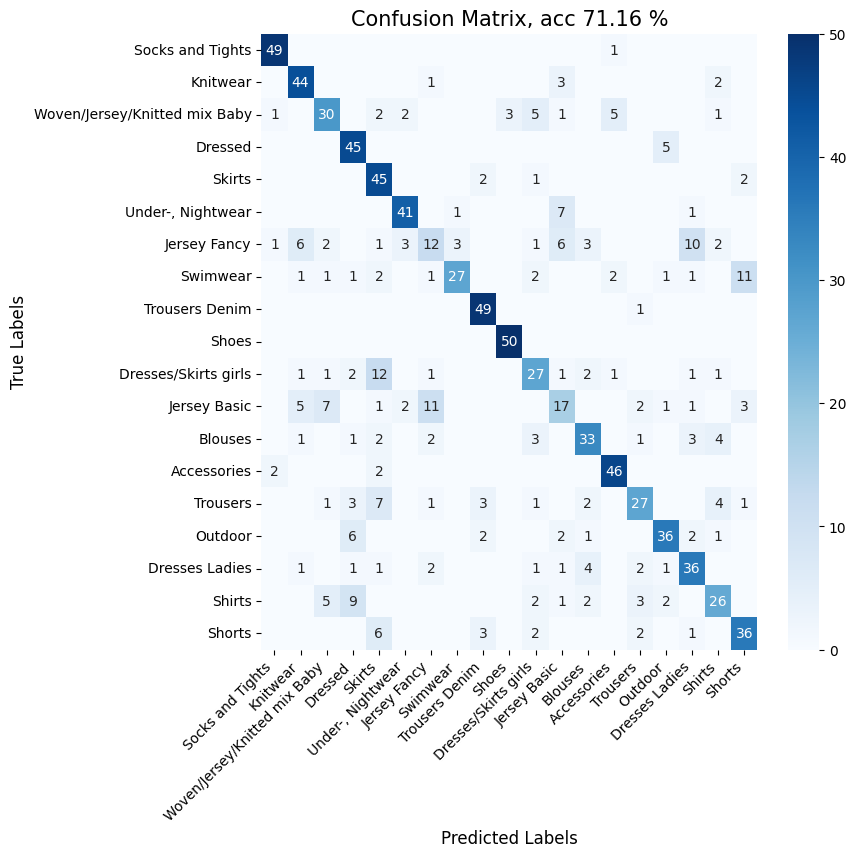

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=1e-05, wd=0.0 is 71.16 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 56%|█████▌    | 28/50 [01:19<01:02,  2.86s/it]

Patience is 2 / 10


 66%|██████▌   | 33/50 [01:33<00:48,  2.84s/it]

Patience is 2 / 10


 76%|███████▌  | 38/50 [01:47<00:33,  2.81s/it]

Patience is 2 / 10


 86%|████████▌ | 43/50 [02:02<00:20,  2.91s/it]

Patience is 2 / 10


 96%|█████████▌| 48/50 [02:16<00:05,  2.83s/it]

Patience is 2 / 10


100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Accuracyasdasdas 70.7368392944336


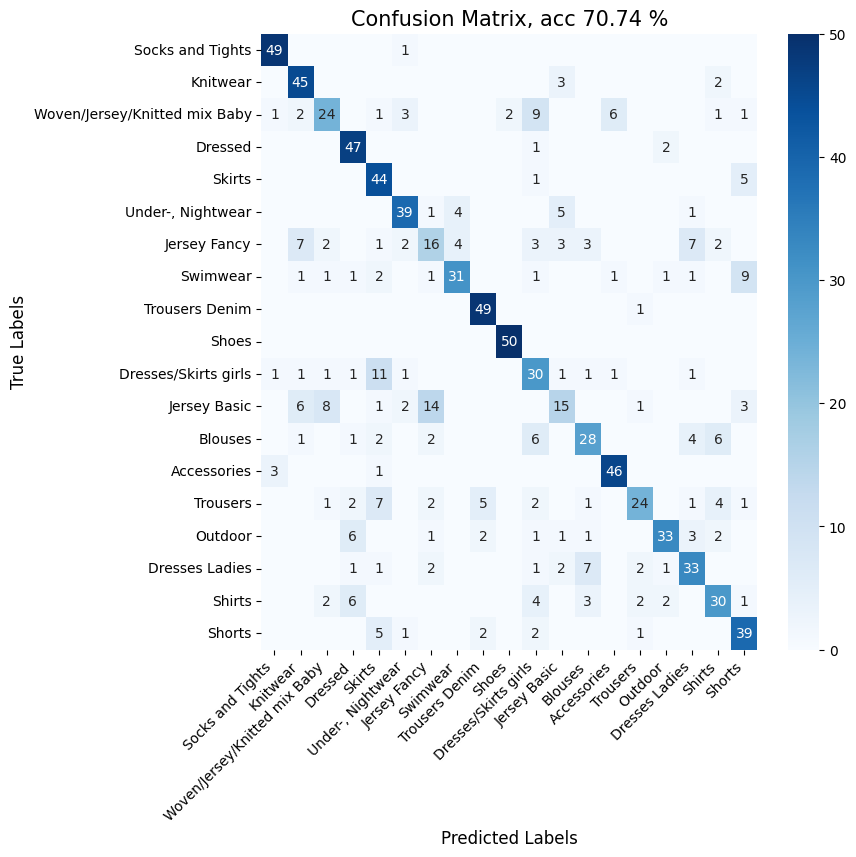

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=1e-05, wd=0.0 is 70.74 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 44%|████▍     | 22/50 [01:10<01:30,  3.22s/it]

Patience is 2 / 10


 54%|█████▍    | 27/50 [01:27<01:14,  3.25s/it]

Patience is 2 / 10


 56%|█████▌    | 28/50 [01:30<01:11,  3.23s/it]

Patience is 3 / 10


 62%|██████▏   | 31/50 [01:39<01:01,  3.24s/it]

Patience is 2 / 10


 76%|███████▌  | 38/50 [02:02<00:39,  3.32s/it]

Patience is 2 / 10


 78%|███████▊  | 39/50 [02:06<00:36,  3.30s/it]

Patience is 3 / 10


 84%|████████▍ | 42/50 [02:16<00:26,  3.29s/it]

Patience is 2 / 10


 86%|████████▌ | 43/50 [02:19<00:23,  3.29s/it]

Patience is 3 / 10


 88%|████████▊ | 44/50 [02:22<00:19,  3.24s/it]

Patience is 4 / 10


100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Accuracyasdasdas 70.31578826904297


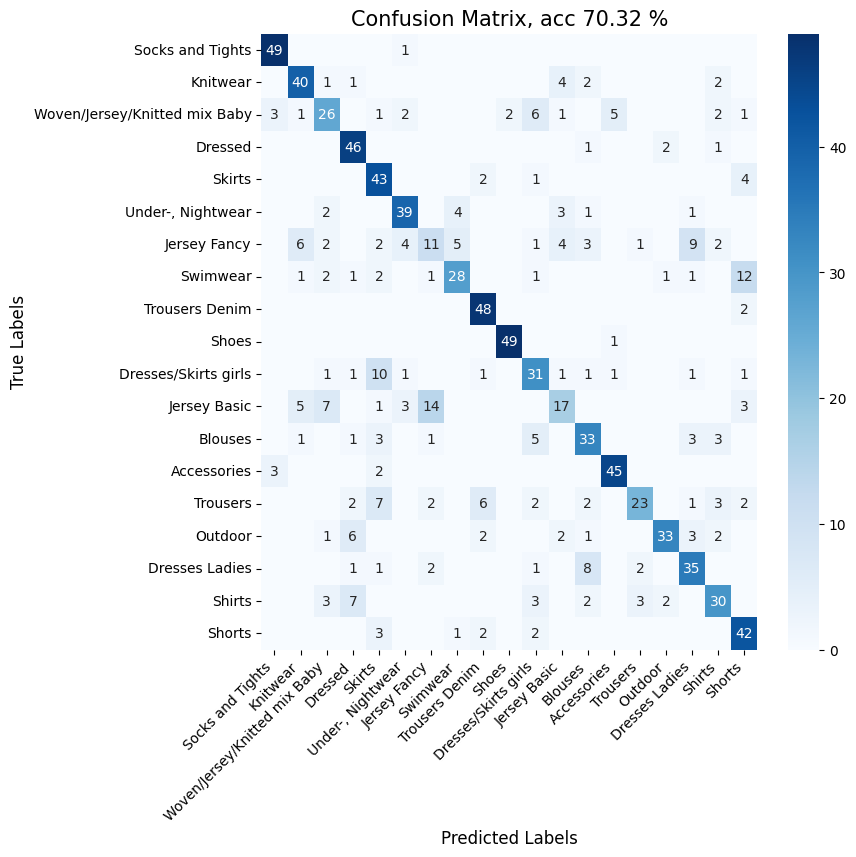

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=1e-05, wd=0.01 is 70.32 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 48%|████▊     | 24/50 [01:07<01:13,  2.83s/it]

Patience is 2 / 10


 66%|██████▌   | 33/50 [01:33<00:49,  2.91s/it]

Patience is 2 / 10


 72%|███████▏  | 36/50 [01:42<00:40,  2.86s/it]

Patience is 2 / 10


 78%|███████▊  | 39/50 [01:50<00:31,  2.86s/it]

Patience is 2 / 10


 80%|████████  | 40/50 [01:53<00:28,  2.87s/it]

Patience is 3 / 10


 86%|████████▌ | 43/50 [02:02<00:19,  2.85s/it]

Patience is 2 / 10


 88%|████████▊ | 44/50 [02:05<00:17,  2.87s/it]

Patience is 3 / 10


 94%|█████████▍| 47/50 [02:13<00:08,  2.85s/it]

Patience is 2 / 10


 96%|█████████▌| 48/50 [02:16<00:05,  2.87s/it]

Patience is 3 / 10


 98%|█████████▊| 49/50 [02:19<00:02,  2.88s/it]

Patience is 4 / 10


100%|██████████| 5/5 [00:00<00:00, 21.46it/s]


Accuracyasdasdas 70.42105102539062


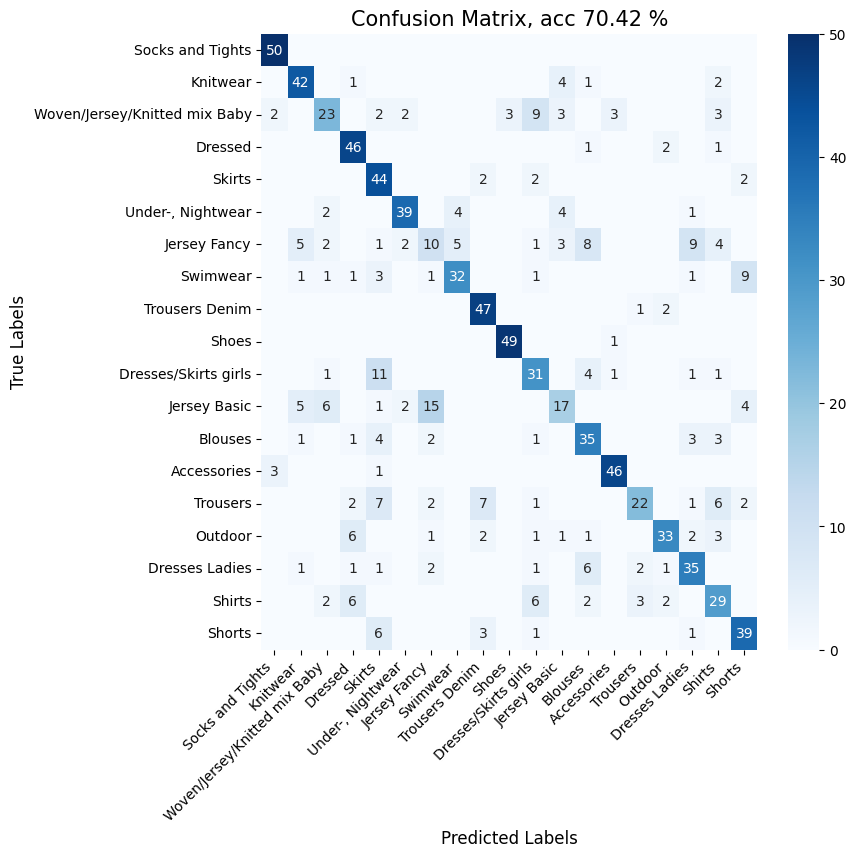

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=1e-05, wd=0.01 is 70.42 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 80%|████████  | 40/50 [02:09<00:32,  3.23s/it]

Patience is 2 / 10


 90%|█████████ | 45/50 [02:25<00:16,  3.24s/it]

Patience is 2 / 10


 92%|█████████▏| 46/50 [02:28<00:12,  3.22s/it]

Patience is 3 / 10


 98%|█████████▊| 49/50 [02:38<00:03,  3.25s/it]

Patience is 2 / 10


100%|██████████| 5/5 [00:00<00:00, 20.95it/s]


Accuracyasdasdas 70.21052551269531


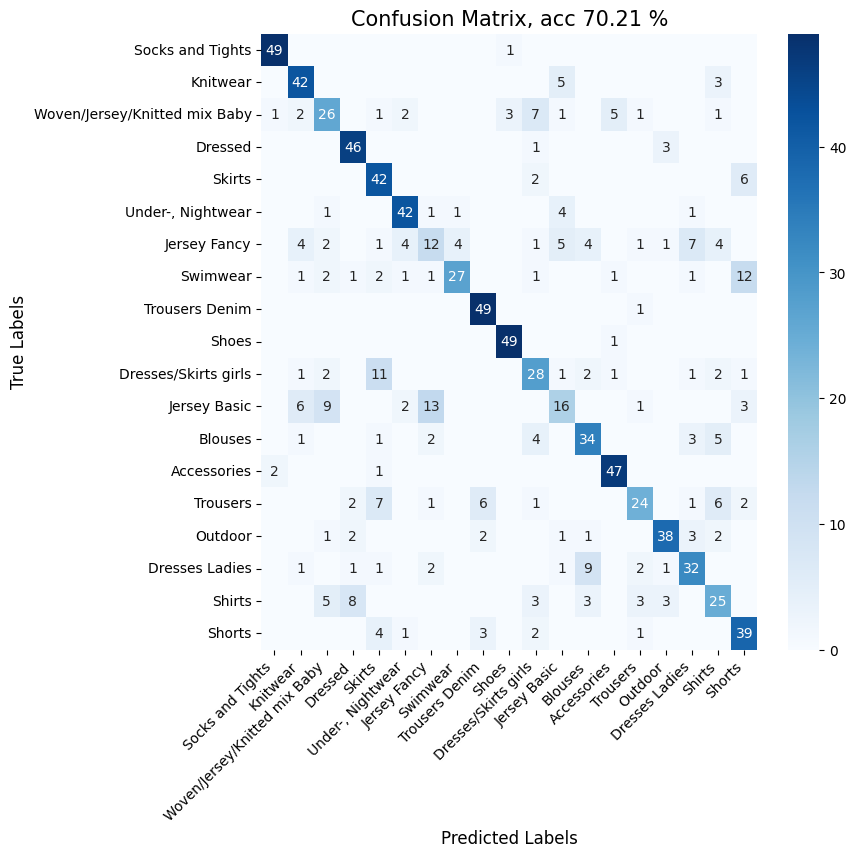

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=1e-05, wd=0.1 is 70.21 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 52%|█████▏    | 26/50 [01:13<01:08,  2.85s/it]

Patience is 2 / 10


 66%|██████▌   | 33/50 [01:33<00:48,  2.86s/it]

Patience is 2 / 10


 88%|████████▊ | 44/50 [02:05<00:17,  2.85s/it]

Patience is 2 / 10


 98%|█████████▊| 49/50 [02:19<00:02,  2.83s/it]

Patience is 2 / 10


100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


Patience is 3 / 10


100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


Accuracyasdasdas 69.36842346191406


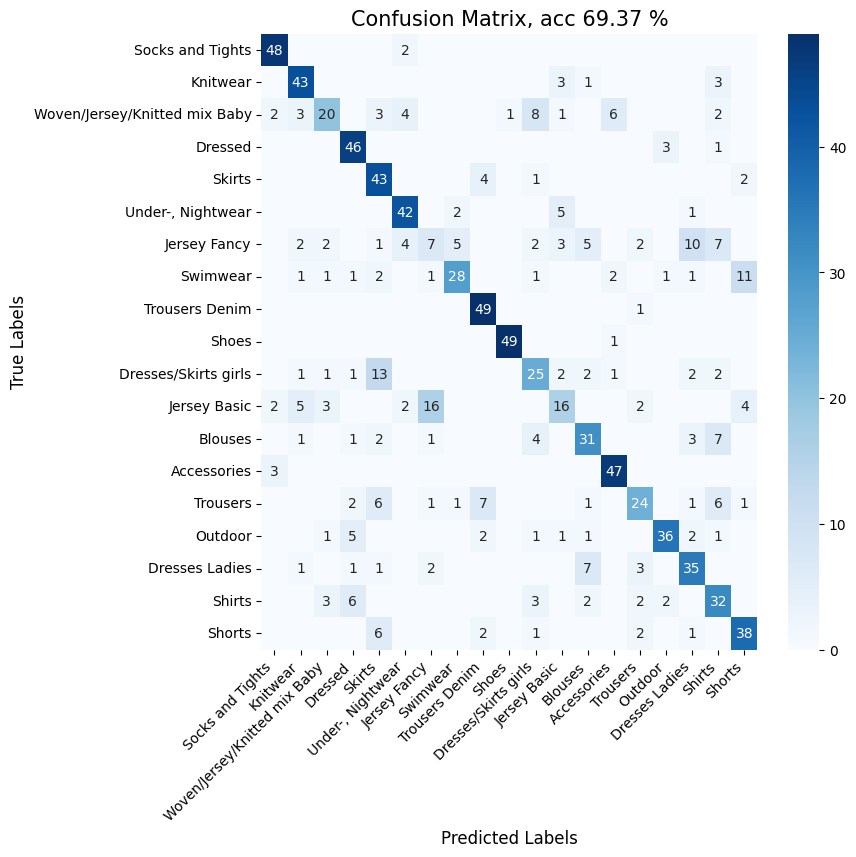

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=1e-05, wd=0.1 is 69.37 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 48%|████▊     | 24/50 [01:17<01:24,  3.24s/it]

Patience is 2 / 10


 62%|██████▏   | 31/50 [01:40<01:01,  3.22s/it]

Patience is 2 / 10


 76%|███████▌  | 38/50 [02:02<00:38,  3.21s/it]

Patience is 2 / 10


 82%|████████▏ | 41/50 [02:12<00:28,  3.20s/it]

Patience is 2 / 10


 96%|█████████▌| 48/50 [02:35<00:06,  3.24s/it]

Patience is 2 / 10


 98%|█████████▊| 49/50 [02:38<00:03,  3.22s/it]

Patience is 3 / 10


100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


Patience is 4 / 10


100%|██████████| 5/5 [00:00<00:00, 20.59it/s]


Accuracyasdasdas 69.89473724365234


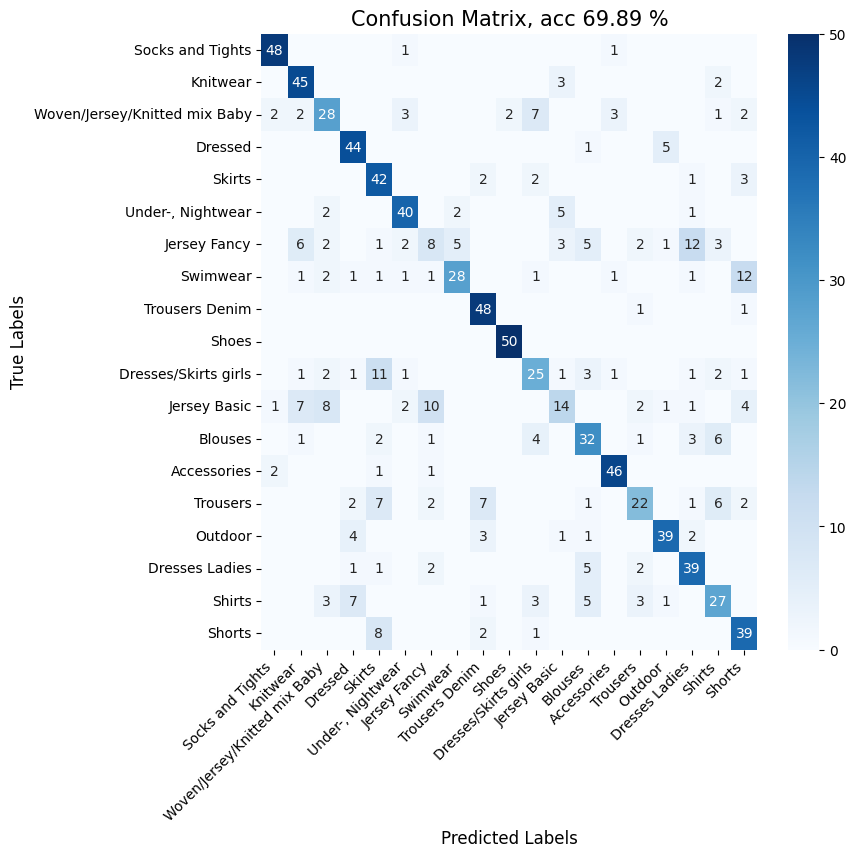

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=1e-05, wd=0.0001 is 69.89 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 44%|████▍     | 22/50 [01:02<01:19,  2.84s/it]

Patience is 2 / 10


 54%|█████▍    | 27/50 [01:16<01:04,  2.81s/it]

Patience is 2 / 10


 64%|██████▍   | 32/50 [01:30<00:50,  2.81s/it]

Patience is 2 / 10


 66%|██████▌   | 33/50 [01:33<00:48,  2.85s/it]

Patience is 3 / 10


 72%|███████▏  | 36/50 [01:42<00:39,  2.85s/it]

Patience is 2 / 10


 82%|████████▏ | 41/50 [01:56<00:25,  2.84s/it]

Patience is 2 / 10


100%|██████████| 50/50 [02:22<00:00,  2.84s/it]


Patience is 2 / 10


100%|██████████| 5/5 [00:00<00:00, 21.81it/s]


Accuracyasdasdas 69.78947448730469


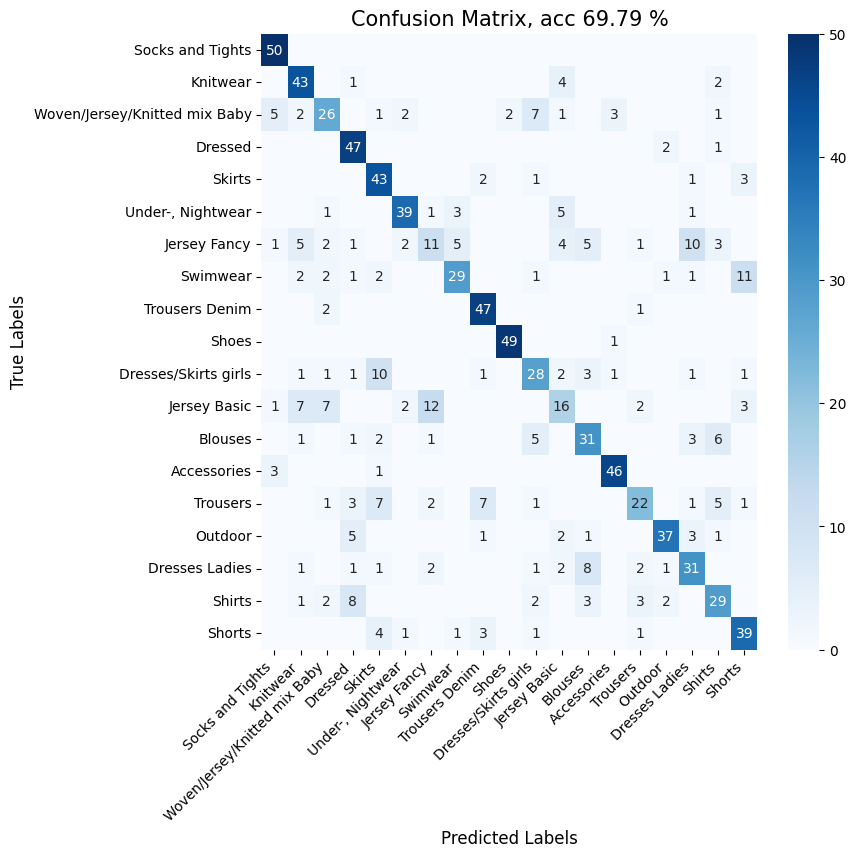

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=1e-05, wd=0.0001 is 69.79 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 16%|█▌        | 8/50 [00:25<02:14,  3.21s/it]

Patience is 2 / 10


 22%|██▏       | 11/50 [00:35<02:04,  3.20s/it]

Patience is 2 / 10


 24%|██▍       | 12/50 [00:38<02:01,  3.20s/it]

Patience is 3 / 10


 26%|██▌       | 13/50 [00:41<01:58,  3.20s/it]

Patience is 4 / 10


 32%|███▏      | 16/50 [00:51<01:48,  3.20s/it]

Patience is 2 / 10


 34%|███▍      | 17/50 [00:54<01:45,  3.20s/it]

Patience is 3 / 10


 36%|███▌      | 18/50 [00:57<01:41,  3.18s/it]

Patience is 4 / 10


 38%|███▊      | 19/50 [01:00<01:38,  3.18s/it]

Patience is 5 / 10


 40%|████      | 20/50 [01:03<01:36,  3.20s/it]

Patience is 6 / 10


 42%|████▏     | 21/50 [01:07<01:33,  3.22s/it]

Patience is 7 / 10


 44%|████▍     | 22/50 [01:10<01:30,  3.23s/it]

Patience is 8 / 10


 46%|████▌     | 23/50 [01:13<01:26,  3.20s/it]

Patience is 9 / 10


 46%|████▌     | 23/50 [01:16<01:30,  3.34s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 20.96it/s]


Accuracyasdasdas 70.42105102539062


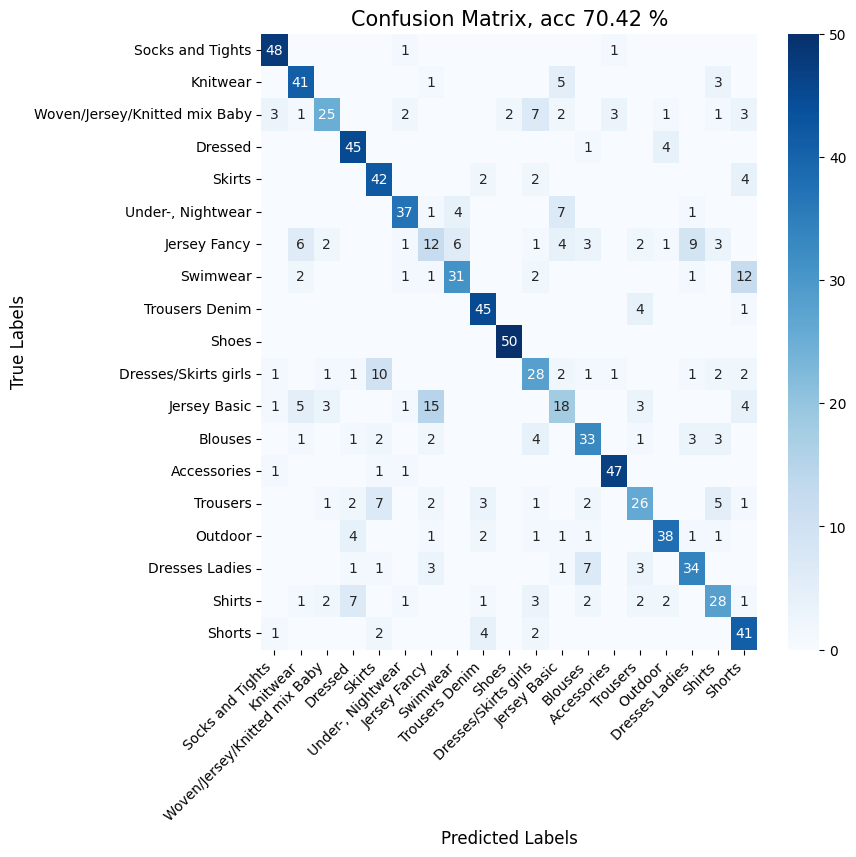

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=5e-05, wd=0.0 is 70.42 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 28%|██▊       | 14/50 [00:39<01:42,  2.84s/it]

Patience is 2 / 10


 30%|███       | 15/50 [00:42<01:40,  2.87s/it]

Patience is 3 / 10


 36%|███▌      | 18/50 [00:50<01:30,  2.83s/it]

Patience is 2 / 10


 46%|████▌     | 23/50 [01:04<01:15,  2.80s/it]

Patience is 2 / 10


 48%|████▊     | 24/50 [01:07<01:12,  2.80s/it]

Patience is 3 / 10


 50%|█████     | 25/50 [01:10<01:10,  2.81s/it]

Patience is 4 / 10


 52%|█████▏    | 26/50 [01:13<01:07,  2.80s/it]

Patience is 5 / 10


 58%|█████▊    | 29/50 [01:21<01:00,  2.87s/it]

Patience is 2 / 10


 64%|██████▍   | 32/50 [01:30<00:50,  2.82s/it]

Patience is 2 / 10


 66%|██████▌   | 33/50 [01:33<00:48,  2.83s/it]

Patience is 3 / 10


 68%|██████▊   | 34/50 [01:35<00:45,  2.82s/it]

Patience is 4 / 10


 70%|███████   | 35/50 [01:38<00:42,  2.82s/it]

Patience is 5 / 10


 72%|███████▏  | 36/50 [01:41<00:39,  2.83s/it]

Patience is 6 / 10


 74%|███████▍  | 37/50 [01:44<00:37,  2.85s/it]

Patience is 7 / 10


 76%|███████▌  | 38/50 [01:47<00:34,  2.84s/it]

Patience is 8 / 10


 78%|███████▊  | 39/50 [01:50<00:31,  2.82s/it]

Patience is 9 / 10


 78%|███████▊  | 39/50 [01:52<00:31,  2.90s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 21.47it/s]


Accuracyasdasdas 71.2631607055664


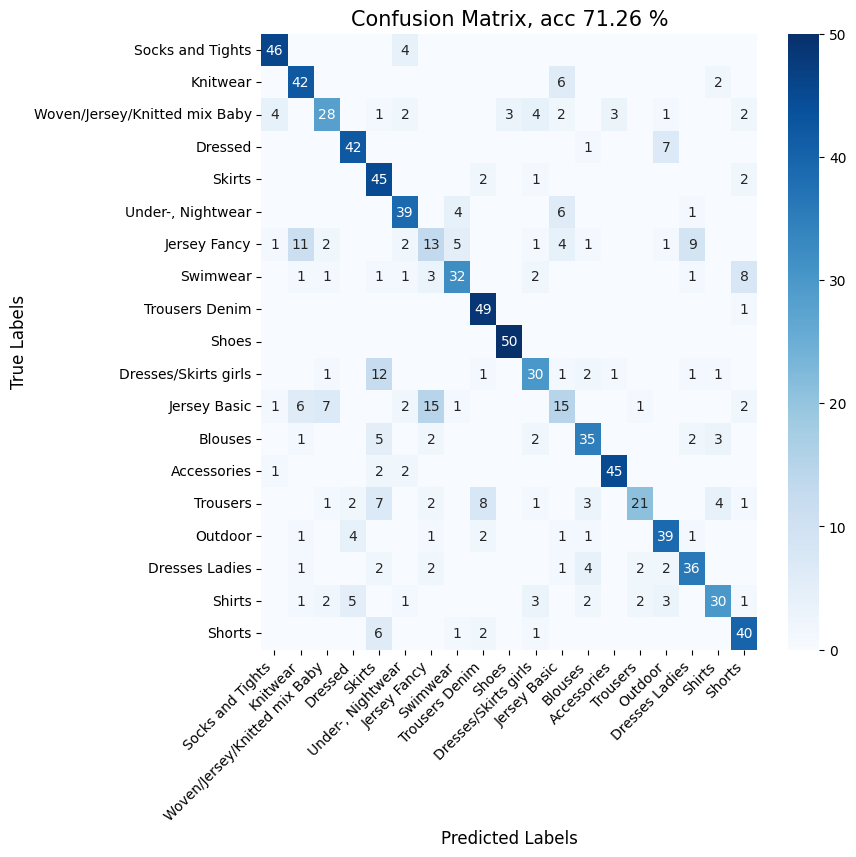

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=5e-05, wd=0.0 is 71.26 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 48%|████▊     | 24/50 [01:16<01:23,  3.20s/it]

Patience is 2 / 10


 50%|█████     | 25/50 [01:19<01:19,  3.18s/it]

Patience is 3 / 10


 52%|█████▏    | 26/50 [01:22<01:16,  3.18s/it]

Patience is 4 / 10


 54%|█████▍    | 27/50 [01:26<01:13,  3.18s/it]

Patience is 5 / 10


 56%|█████▌    | 28/50 [01:29<01:10,  3.22s/it]

Patience is 6 / 10


 58%|█████▊    | 29/50 [01:32<01:07,  3.23s/it]

Patience is 7 / 10


 60%|██████    | 30/50 [01:35<01:04,  3.22s/it]

Patience is 8 / 10


 62%|██████▏   | 31/50 [01:39<01:01,  3.22s/it]

Patience is 9 / 10


 62%|██████▏   | 31/50 [01:42<01:02,  3.31s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 21.03it/s]


Accuracyasdasdas 70.31578826904297


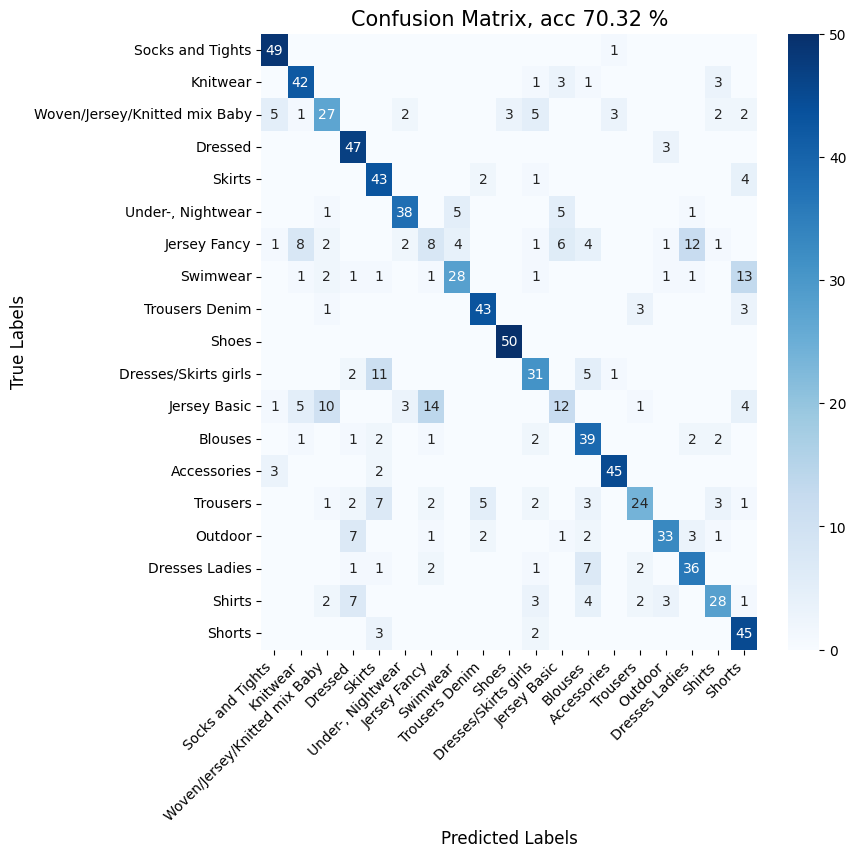

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=5e-05, wd=0.01 is 70.32 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 12%|█▏        | 6/50 [00:16<02:03,  2.80s/it]

Patience is 2 / 10


 50%|█████     | 25/50 [01:10<01:10,  2.81s/it]

Patience is 2 / 10


 56%|█████▌    | 28/50 [01:19<01:02,  2.83s/it]

Patience is 2 / 10


 58%|█████▊    | 29/50 [01:21<00:58,  2.81s/it]

Patience is 3 / 10


 60%|██████    | 30/50 [01:24<00:56,  2.82s/it]

Patience is 4 / 10


 70%|███████   | 35/50 [01:39<00:42,  2.84s/it]

Patience is 2 / 10


 84%|████████▍ | 42/50 [01:58<00:22,  2.83s/it]

Patience is 2 / 10


 86%|████████▌ | 43/50 [02:01<00:19,  2.84s/it]

Patience is 3 / 10


 92%|█████████▏| 46/50 [02:10<00:11,  2.85s/it]

Patience is 2 / 10


 94%|█████████▍| 47/50 [02:13<00:08,  2.84s/it]

Patience is 3 / 10


 96%|█████████▌| 48/50 [02:15<00:05,  2.86s/it]

Patience is 4 / 10


 98%|█████████▊| 49/50 [02:18<00:02,  2.86s/it]

Patience is 5 / 10


100%|██████████| 50/50 [02:22<00:00,  2.84s/it]


Patience is 6 / 10


100%|██████████| 5/5 [00:00<00:00, 22.68it/s]


Accuracyasdasdas 69.2631607055664


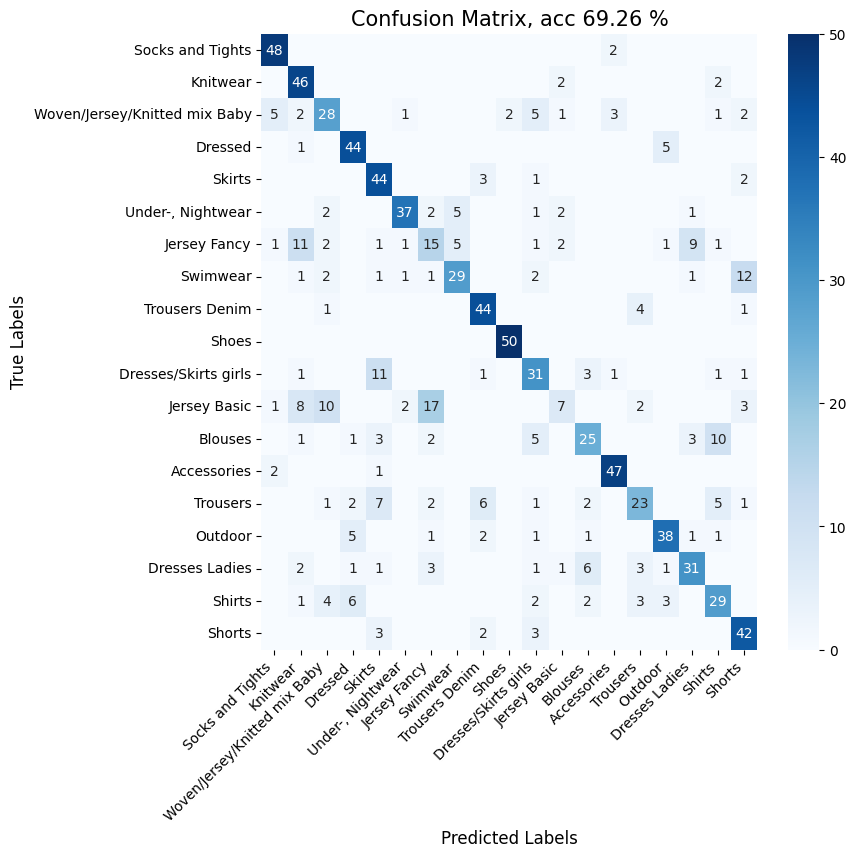

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=5e-05, wd=0.01 is 69.26 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 24%|██▍       | 12/50 [00:38<02:02,  3.22s/it]

Patience is 2 / 10


 26%|██▌       | 13/50 [00:41<01:58,  3.19s/it]

Patience is 3 / 10


 36%|███▌      | 18/50 [00:57<01:43,  3.23s/it]

Patience is 2 / 10


 38%|███▊      | 19/50 [01:00<01:39,  3.21s/it]

Patience is 3 / 10


 44%|████▍     | 22/50 [01:10<01:30,  3.22s/it]

Patience is 2 / 10


 46%|████▌     | 23/50 [01:13<01:26,  3.22s/it]

Patience is 3 / 10


 72%|███████▏  | 36/50 [01:55<00:45,  3.22s/it]

Patience is 2 / 10


 86%|████████▌ | 43/50 [02:18<00:22,  3.19s/it]

Patience is 2 / 10


 88%|████████▊ | 44/50 [02:21<00:19,  3.20s/it]

Patience is 3 / 10


 98%|█████████▊| 49/50 [02:37<00:03,  3.27s/it]

Patience is 2 / 10


100%|██████████| 50/50 [02:41<00:00,  3.22s/it]


Patience is 3 / 10


100%|██████████| 5/5 [00:00<00:00, 21.64it/s]


Accuracyasdasdas 70.21052551269531


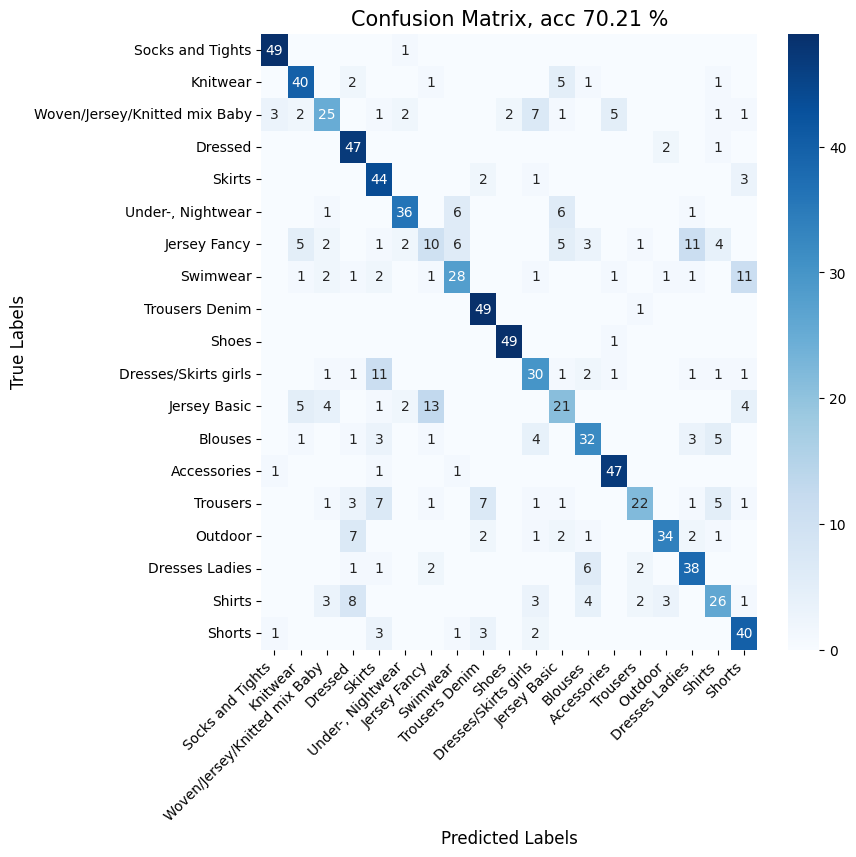

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=5e-05, wd=0.1 is 70.21 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 36%|███▌      | 18/50 [00:50<01:30,  2.83s/it]

Patience is 2 / 10


 46%|████▌     | 23/50 [01:05<01:17,  2.87s/it]

Patience is 2 / 10


 48%|████▊     | 24/50 [01:08<01:14,  2.85s/it]

Patience is 3 / 10


 54%|█████▍    | 27/50 [01:16<01:05,  2.83s/it]

Patience is 2 / 10


 64%|██████▍   | 32/50 [01:30<00:50,  2.83s/it]

Patience is 2 / 10


 70%|███████   | 35/50 [01:39<00:42,  2.84s/it]

Patience is 2 / 10


 72%|███████▏  | 36/50 [01:42<00:39,  2.85s/it]

Patience is 3 / 10


 74%|███████▍  | 37/50 [01:45<00:37,  2.86s/it]

Patience is 4 / 10


 80%|████████  | 40/50 [01:53<00:28,  2.86s/it]

Patience is 2 / 10


 82%|████████▏ | 41/50 [01:56<00:25,  2.83s/it]

Patience is 3 / 10


 92%|█████████▏| 46/50 [02:11<00:11,  2.87s/it]

Patience is 2 / 10


 94%|█████████▍| 47/50 [02:13<00:08,  2.89s/it]

Patience is 3 / 10


100%|██████████| 5/5 [00:00<00:00, 22.12it/s]


Accuracyasdasdas 70.52631378173828


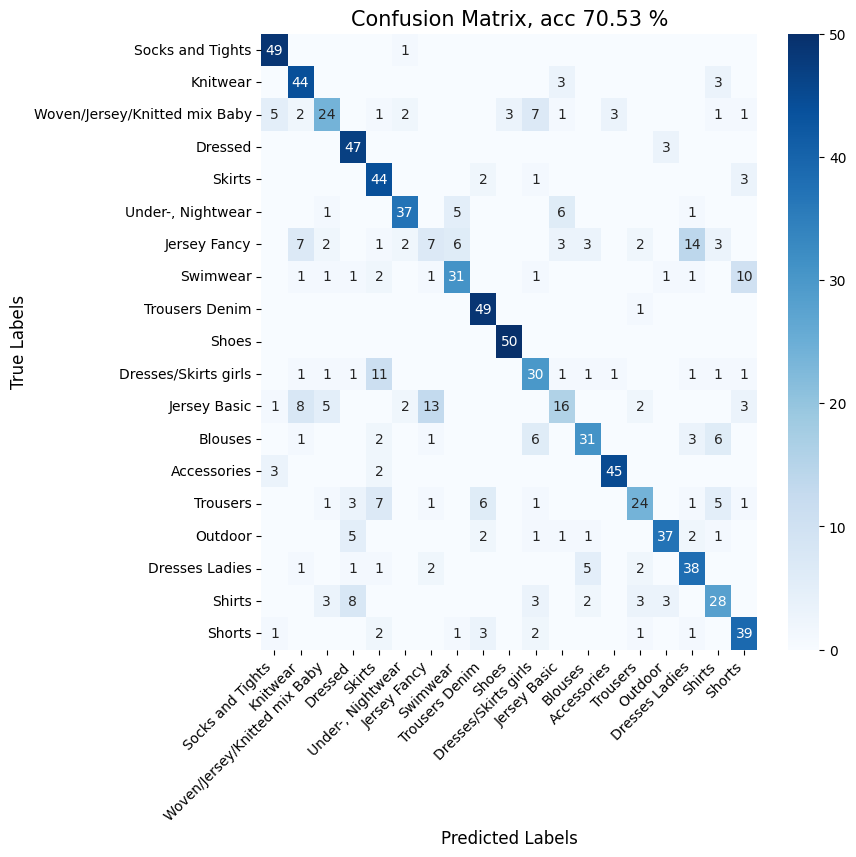

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=5e-05, wd=0.1 is 70.53 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 24%|██▍       | 12/50 [00:38<02:00,  3.17s/it]

Patience is 2 / 10


 26%|██▌       | 13/50 [00:41<01:58,  3.20s/it]

Patience is 3 / 10


 28%|██▊       | 14/50 [00:44<01:55,  3.22s/it]

Patience is 4 / 10


 42%|████▏     | 21/50 [01:07<01:34,  3.24s/it]

Patience is 2 / 10


 44%|████▍     | 22/50 [01:10<01:29,  3.21s/it]

Patience is 3 / 10


 50%|█████     | 25/50 [01:20<01:21,  3.25s/it]

Patience is 2 / 10


 52%|█████▏    | 26/50 [01:23<01:17,  3.23s/it]

Patience is 3 / 10


 54%|█████▍    | 27/50 [01:26<01:14,  3.23s/it]

Patience is 4 / 10


 56%|█████▌    | 28/50 [01:29<01:10,  3.20s/it]

Patience is 5 / 10


 58%|█████▊    | 29/50 [01:33<01:07,  3.22s/it]

Patience is 6 / 10


 60%|██████    | 30/50 [01:36<01:04,  3.23s/it]

Patience is 7 / 10


 62%|██████▏   | 31/50 [01:39<01:01,  3.22s/it]

Patience is 8 / 10


 64%|██████▍   | 32/50 [01:42<00:57,  3.20s/it]

Patience is 9 / 10


 64%|██████▍   | 32/50 [01:45<00:59,  3.31s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 21.14it/s]


Accuracyasdasdas 70.42105102539062


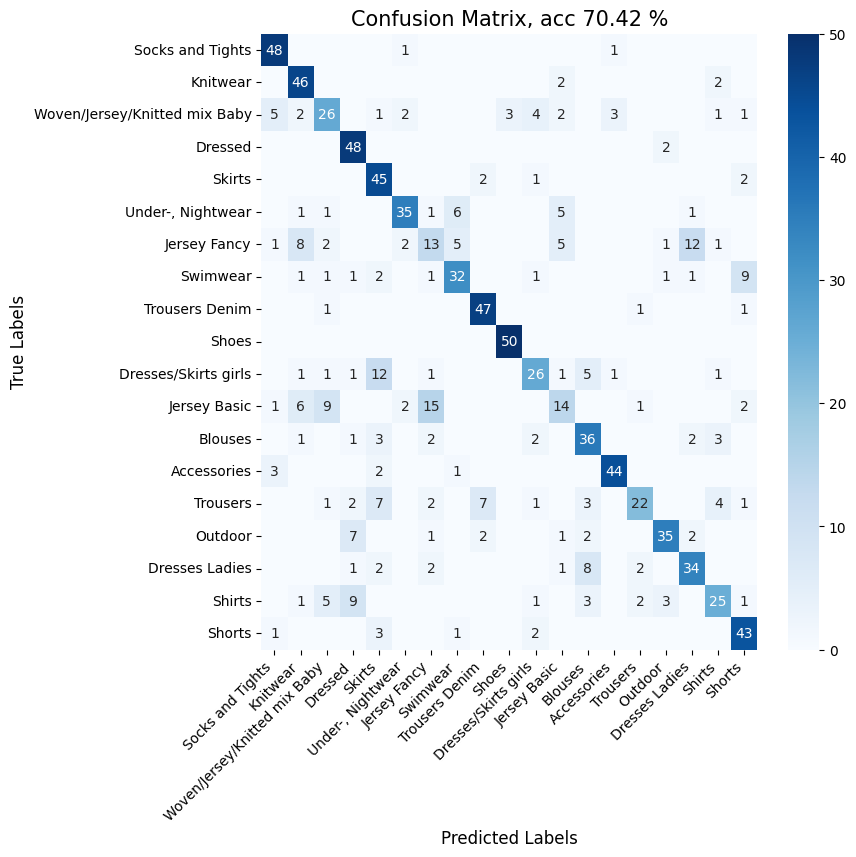

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=5e-05, wd=0.0001 is 70.42 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 20%|██        | 10/50 [00:28<01:52,  2.82s/it]

Patience is 2 / 10


 22%|██▏       | 11/50 [00:31<01:50,  2.84s/it]

Patience is 3 / 10


 32%|███▏      | 16/50 [00:45<01:36,  2.84s/it]

Patience is 2 / 10


 38%|███▊      | 19/50 [00:53<01:28,  2.85s/it]

Patience is 2 / 10


 40%|████      | 20/50 [00:56<01:25,  2.83s/it]

Patience is 3 / 10


 42%|████▏     | 21/50 [00:59<01:22,  2.83s/it]

Patience is 4 / 10


 56%|█████▌    | 28/50 [01:19<01:02,  2.86s/it]

Patience is 2 / 10


 58%|█████▊    | 29/50 [01:22<00:59,  2.85s/it]

Patience is 3 / 10


 60%|██████    | 30/50 [01:25<00:56,  2.85s/it]

Patience is 4 / 10


 62%|██████▏   | 31/50 [01:28<00:53,  2.84s/it]

Patience is 5 / 10


 64%|██████▍   | 32/50 [01:30<00:51,  2.84s/it]

Patience is 6 / 10


 66%|██████▌   | 33/50 [01:33<00:48,  2.84s/it]

Patience is 7 / 10


 68%|██████▊   | 34/50 [01:36<00:45,  2.86s/it]

Patience is 8 / 10


 70%|███████   | 35/50 [01:39<00:43,  2.87s/it]

Patience is 9 / 10


 84%|████████▍ | 42/50 [01:59<00:22,  2.86s/it]

Patience is 2 / 10


 86%|████████▌ | 43/50 [02:02<00:19,  2.85s/it]

Patience is 3 / 10


 88%|████████▊ | 44/50 [02:05<00:17,  2.87s/it]

Patience is 4 / 10


 90%|█████████ | 45/50 [02:08<00:14,  2.86s/it]

Patience is 5 / 10


 92%|█████████▏| 46/50 [02:10<00:11,  2.85s/it]

Patience is 6 / 10


 94%|█████████▍| 47/50 [02:13<00:08,  2.85s/it]

Patience is 7 / 10


 96%|█████████▌| 48/50 [02:16<00:05,  2.87s/it]

Patience is 8 / 10


 98%|█████████▊| 49/50 [02:19<00:02,  2.85s/it]

Patience is 9 / 10


 98%|█████████▊| 49/50 [02:22<00:02,  2.90s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


Accuracyasdasdas 70.31578826904297


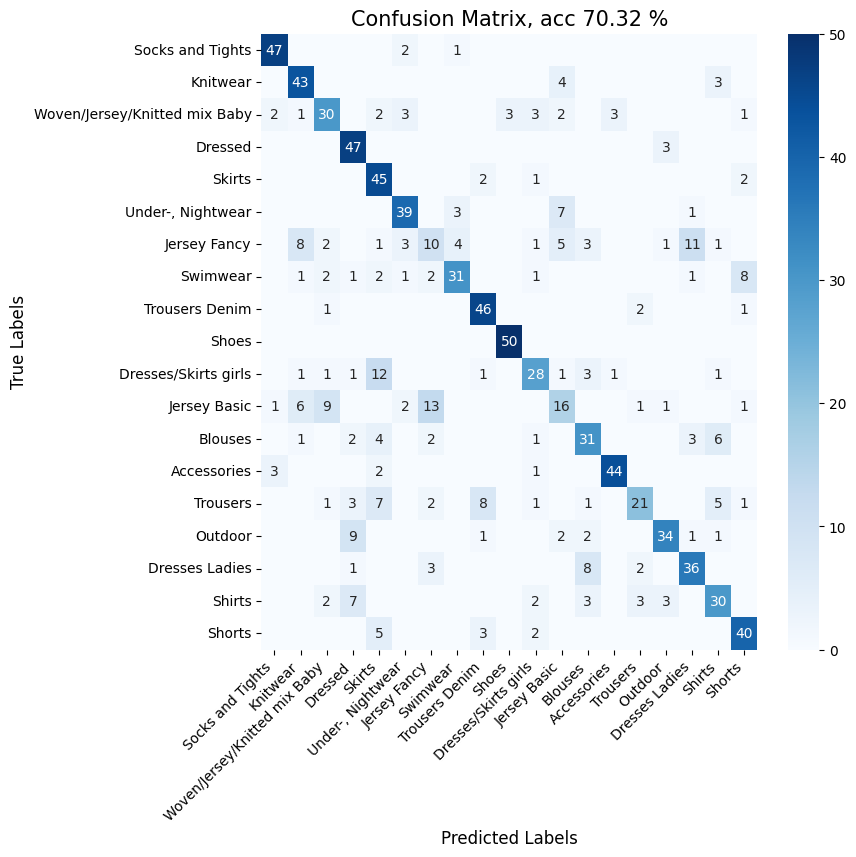

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=5e-05, wd=0.0001 is 70.32 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 24%|██▍       | 12/50 [00:38<02:02,  3.22s/it]

Patience is 2 / 10


 58%|█████▊    | 29/50 [01:32<01:06,  3.16s/it]

Patience is 2 / 10


 60%|██████    | 30/50 [01:35<01:04,  3.20s/it]

Patience is 3 / 10


 78%|███████▊  | 39/50 [02:04<00:35,  3.20s/it]

Patience is 2 / 10


 80%|████████  | 40/50 [02:07<00:31,  3.18s/it]

Patience is 3 / 10


 82%|████████▏ | 41/50 [02:11<00:28,  3.19s/it]

Patience is 4 / 10


 88%|████████▊ | 44/50 [02:20<00:19,  3.19s/it]

Patience is 2 / 10


 90%|█████████ | 45/50 [02:23<00:15,  3.18s/it]

Patience is 3 / 10


 92%|█████████▏| 46/50 [02:27<00:12,  3.19s/it]

Patience is 4 / 10


 94%|█████████▍| 47/50 [02:30<00:09,  3.18s/it]

Patience is 5 / 10


100%|██████████| 50/50 [02:40<00:00,  3.20s/it]


Patience is 2 / 10


100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


Accuracyasdasdas 70.52631378173828


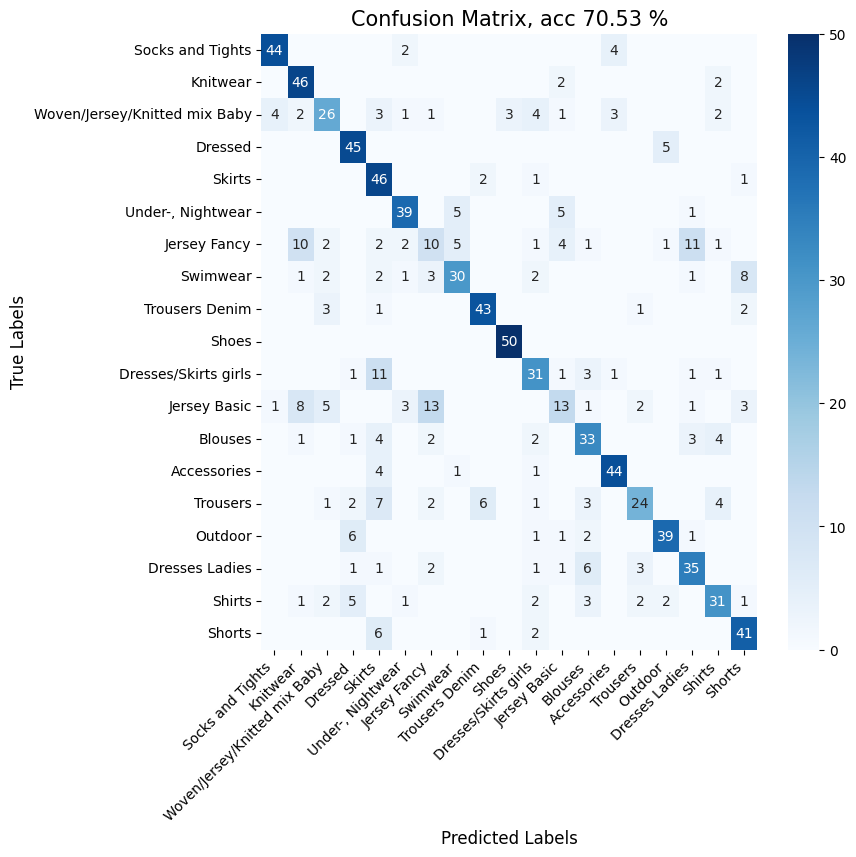

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=0.0001, wd=0.0 is 70.53 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 24%|██▍       | 12/50 [00:33<01:46,  2.81s/it]

Patience is 2 / 10


 38%|███▊      | 19/50 [00:53<01:28,  2.84s/it]

Patience is 2 / 10


 48%|████▊     | 24/50 [01:07<01:12,  2.80s/it]

Patience is 2 / 10


 50%|█████     | 25/50 [01:10<01:09,  2.80s/it]

Patience is 3 / 10


 52%|█████▏    | 26/50 [01:13<01:07,  2.83s/it]

Patience is 4 / 10


 54%|█████▍    | 27/50 [01:16<01:05,  2.84s/it]

Patience is 5 / 10


 80%|████████  | 40/50 [01:52<00:28,  2.85s/it]

Patience is 2 / 10


 86%|████████▌ | 43/50 [02:01<00:19,  2.84s/it]

Patience is 2 / 10


 88%|████████▊ | 44/50 [02:04<00:16,  2.83s/it]

Patience is 3 / 10


 90%|█████████ | 45/50 [02:07<00:14,  2.85s/it]

Patience is 4 / 10


100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


Patience is 2 / 10


100%|██████████| 5/5 [00:00<00:00, 23.19it/s]


Accuracyasdasdas 69.47368621826172


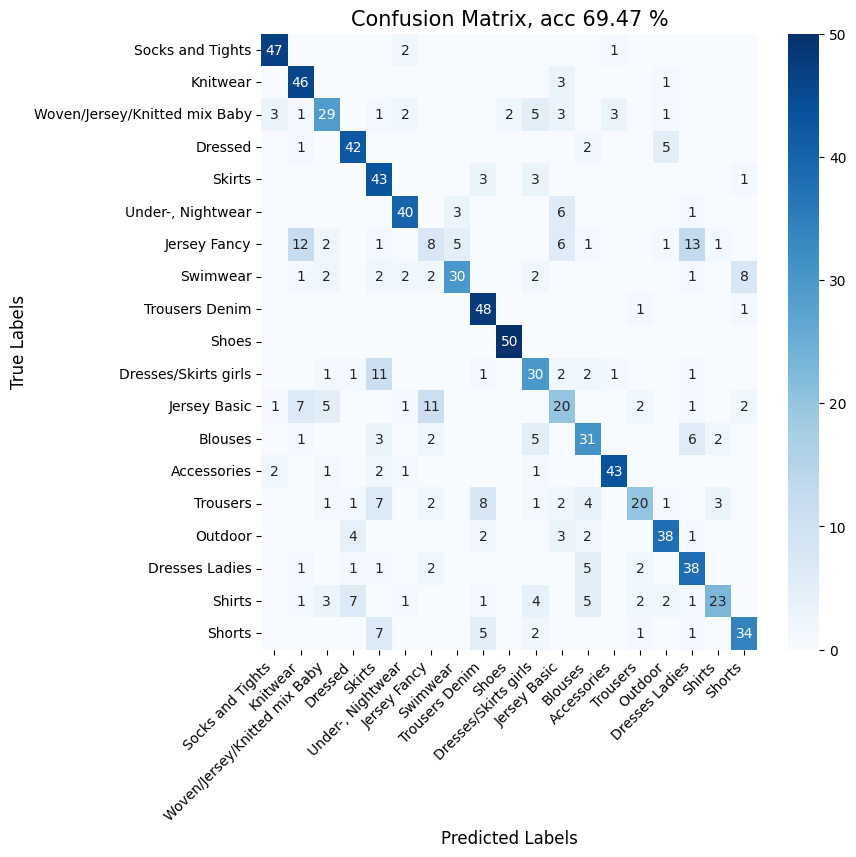

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=0.0001, wd=0.0 is 69.47 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 20%|██        | 10/50 [00:31<02:08,  3.21s/it]

Patience is 2 / 10


 22%|██▏       | 11/50 [00:35<02:04,  3.20s/it]

Patience is 3 / 10


 32%|███▏      | 16/50 [00:51<01:48,  3.18s/it]

Patience is 2 / 10


 38%|███▊      | 19/50 [01:00<01:38,  3.18s/it]

Patience is 2 / 10


 44%|████▍     | 22/50 [01:10<01:29,  3.18s/it]

Patience is 2 / 10


 46%|████▌     | 23/50 [01:13<01:25,  3.18s/it]

Patience is 3 / 10


 48%|████▊     | 24/50 [01:16<01:22,  3.16s/it]

Patience is 4 / 10


 50%|█████     | 25/50 [01:19<01:19,  3.18s/it]

Patience is 5 / 10


 52%|█████▏    | 26/50 [01:22<01:16,  3.18s/it]

Patience is 6 / 10


 54%|█████▍    | 27/50 [01:26<01:13,  3.18s/it]

Patience is 7 / 10


 56%|█████▌    | 28/50 [01:29<01:10,  3.20s/it]

Patience is 8 / 10


 58%|█████▊    | 29/50 [01:32<01:07,  3.22s/it]

Patience is 9 / 10


 58%|█████▊    | 29/50 [01:35<01:09,  3.30s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 21.28it/s]


Accuracyasdasdas 70.31578826904297


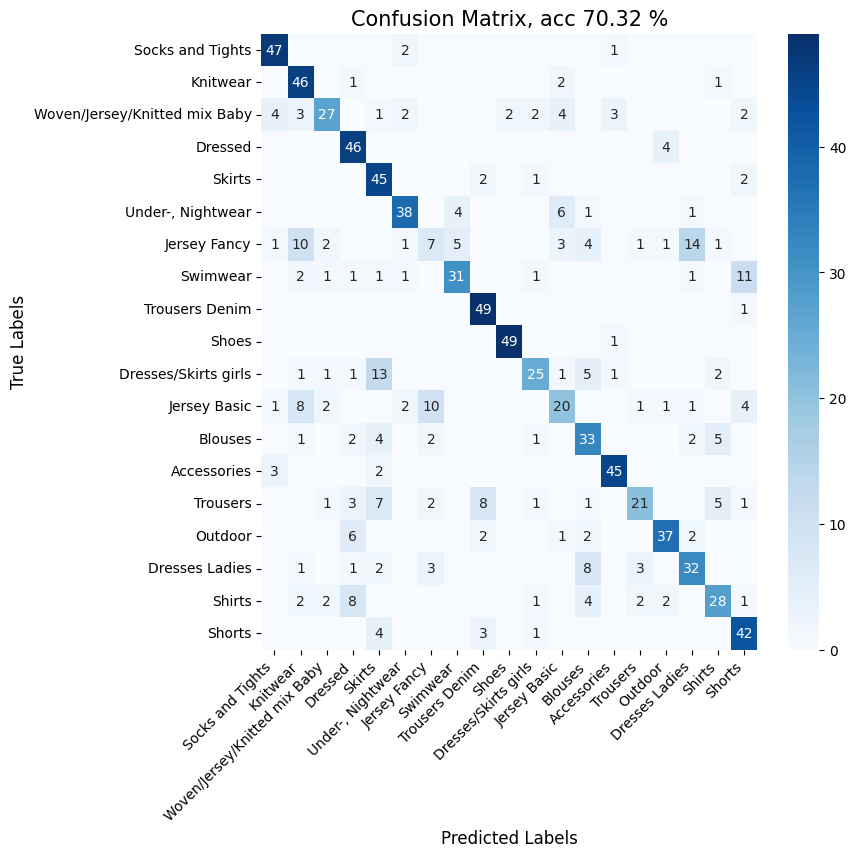

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=0.0001, wd=0.01 is 70.32 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 12%|█▏        | 6/50 [00:16<02:04,  2.83s/it]

Patience is 2 / 10


 26%|██▌       | 13/50 [00:37<01:49,  2.95s/it]

Patience is 2 / 10


 28%|██▊       | 14/50 [00:40<01:45,  2.92s/it]

Patience is 3 / 10


 30%|███       | 15/50 [00:43<01:41,  2.91s/it]

Patience is 4 / 10


 32%|███▏      | 16/50 [00:46<01:39,  2.92s/it]

Patience is 5 / 10


 34%|███▍      | 17/50 [00:48<01:35,  2.91s/it]

Patience is 6 / 10


 36%|███▌      | 18/50 [00:51<01:31,  2.87s/it]

Patience is 7 / 10


 42%|████▏     | 21/50 [01:00<01:23,  2.88s/it]

Patience is 2 / 10


 48%|████▊     | 24/50 [01:08<01:14,  2.85s/it]

Patience is 2 / 10


 58%|█████▊    | 29/50 [01:23<00:59,  2.84s/it]

Patience is 2 / 10


 60%|██████    | 30/50 [01:25<00:56,  2.85s/it]

Patience is 3 / 10


 66%|██████▌   | 33/50 [01:34<00:48,  2.86s/it]

Patience is 2 / 10


 68%|██████▊   | 34/50 [01:37<00:45,  2.87s/it]

Patience is 3 / 10


 70%|███████   | 35/50 [01:40<00:43,  2.89s/it]

Patience is 4 / 10


 72%|███████▏  | 36/50 [01:43<00:40,  2.89s/it]

Patience is 5 / 10


 82%|████████▏ | 41/50 [01:57<00:25,  2.86s/it]

Patience is 2 / 10


 84%|████████▍ | 42/50 [02:00<00:22,  2.85s/it]

Patience is 3 / 10


 86%|████████▌ | 43/50 [02:03<00:20,  2.86s/it]

Patience is 4 / 10


 92%|█████████▏| 46/50 [02:11<00:11,  2.84s/it]

Patience is 2 / 10


 94%|█████████▍| 47/50 [02:14<00:08,  2.87s/it]

Patience is 3 / 10


 96%|█████████▌| 48/50 [02:17<00:05,  2.88s/it]

Patience is 4 / 10


 98%|█████████▊| 49/50 [02:20<00:02,  2.88s/it]

Patience is 5 / 10


100%|██████████| 50/50 [02:23<00:00,  2.87s/it]


Patience is 6 / 10


100%|██████████| 5/5 [00:00<00:00, 22.40it/s]


Accuracyasdasdas 70.7368392944336


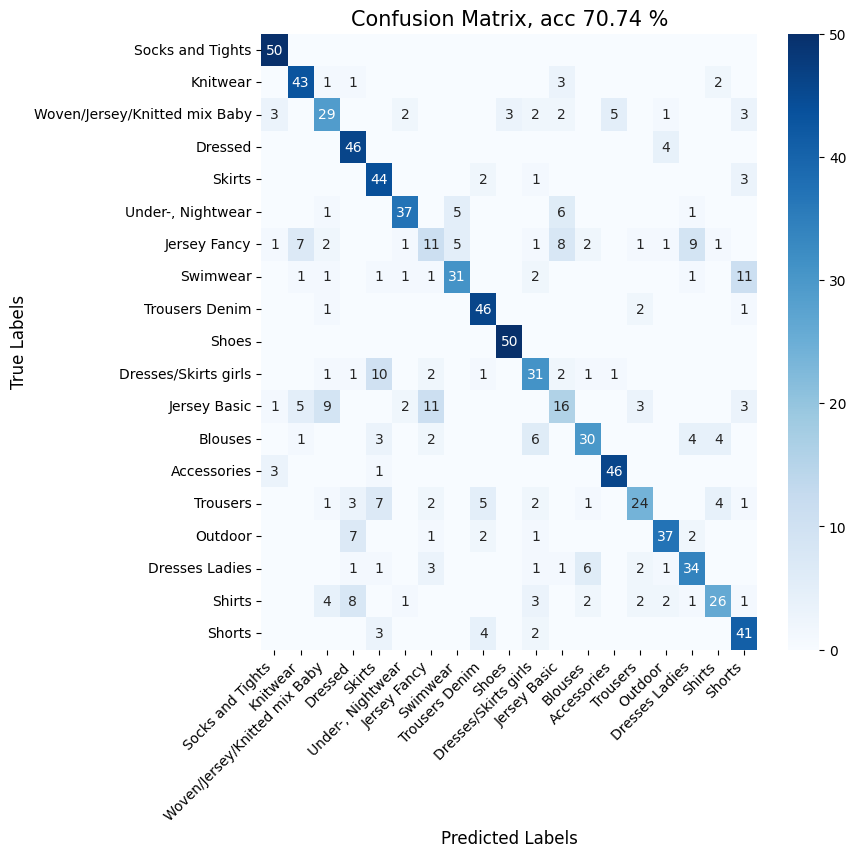

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=0.0001, wd=0.01 is 70.74 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 16%|█▌        | 8/50 [00:25<02:14,  3.20s/it]

Patience is 2 / 10


 30%|███       | 15/50 [00:48<01:53,  3.25s/it]

Patience is 2 / 10


 32%|███▏      | 16/50 [00:51<01:49,  3.23s/it]

Patience is 3 / 10


 34%|███▍      | 17/50 [00:54<01:46,  3.22s/it]

Patience is 4 / 10


 36%|███▌      | 18/50 [00:58<01:43,  3.24s/it]

Patience is 5 / 10


 38%|███▊      | 19/50 [01:01<01:40,  3.23s/it]

Patience is 6 / 10


 40%|████      | 20/50 [01:04<01:37,  3.24s/it]

Patience is 7 / 10


 54%|█████▍    | 27/50 [01:27<01:14,  3.25s/it]

Patience is 2 / 10


 56%|█████▌    | 28/50 [01:30<01:11,  3.25s/it]

Patience is 3 / 10


 58%|█████▊    | 29/50 [01:33<01:08,  3.26s/it]

Patience is 4 / 10


 60%|██████    | 30/50 [01:37<01:05,  3.25s/it]

Patience is 5 / 10


 74%|███████▍  | 37/50 [01:59<00:42,  3.24s/it]

Patience is 2 / 10


 76%|███████▌  | 38/50 [02:02<00:38,  3.22s/it]

Patience is 3 / 10


 98%|█████████▊| 49/50 [02:38<00:03,  3.23s/it]

Patience is 2 / 10


100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


Patience is 3 / 10


100%|██████████| 5/5 [00:00<00:00, 20.87it/s]


Accuracyasdasdas 70.52631378173828


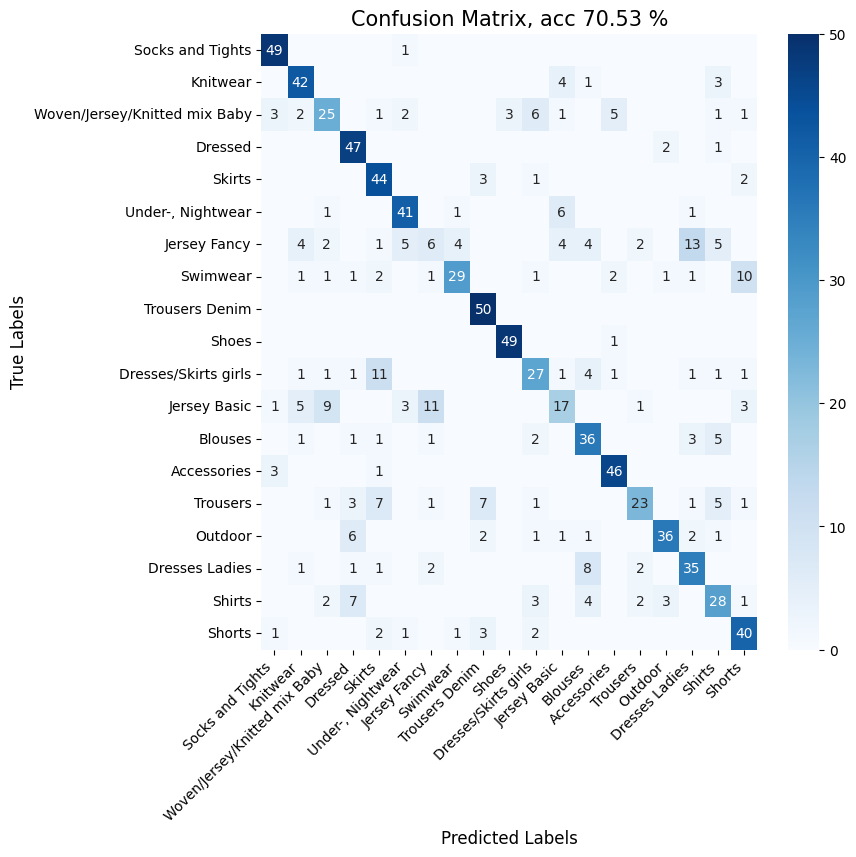

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=0.0001, wd=0.1 is 70.53 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 20%|██        | 10/50 [00:28<01:55,  2.89s/it]

Patience is 2 / 10


 30%|███       | 15/50 [00:42<01:40,  2.88s/it]

Patience is 2 / 10


 36%|███▌      | 18/50 [00:51<01:31,  2.86s/it]

Patience is 2 / 10


 38%|███▊      | 19/50 [00:54<01:28,  2.86s/it]

Patience is 3 / 10


 40%|████      | 20/50 [00:57<01:25,  2.84s/it]

Patience is 4 / 10


 42%|████▏     | 21/50 [00:59<01:23,  2.87s/it]

Patience is 5 / 10


 44%|████▍     | 22/50 [01:02<01:20,  2.86s/it]

Patience is 6 / 10


 46%|████▌     | 23/50 [01:05<01:17,  2.85s/it]

Patience is 7 / 10


 48%|████▊     | 24/50 [01:08<01:13,  2.83s/it]

Patience is 8 / 10


 62%|██████▏   | 31/50 [01:28<00:54,  2.88s/it]

Patience is 2 / 10


 72%|███████▏  | 36/50 [01:42<00:39,  2.82s/it]

Patience is 2 / 10


 74%|███████▍  | 37/50 [01:45<00:36,  2.82s/it]

Patience is 3 / 10


 76%|███████▌  | 38/50 [01:48<00:34,  2.85s/it]

Patience is 4 / 10


 78%|███████▊  | 39/50 [01:51<00:31,  2.87s/it]

Patience is 5 / 10


 80%|████████  | 40/50 [01:54<00:28,  2.88s/it]

Patience is 6 / 10


 82%|████████▏ | 41/50 [01:57<00:26,  2.89s/it]

Patience is 7 / 10


 84%|████████▍ | 42/50 [02:00<00:22,  2.87s/it]

Patience is 8 / 10


 86%|████████▌ | 43/50 [02:03<00:20,  2.88s/it]

Patience is 9 / 10


 86%|████████▌ | 43/50 [02:05<00:20,  2.93s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 22.73it/s]


Accuracyasdasdas 69.2631607055664


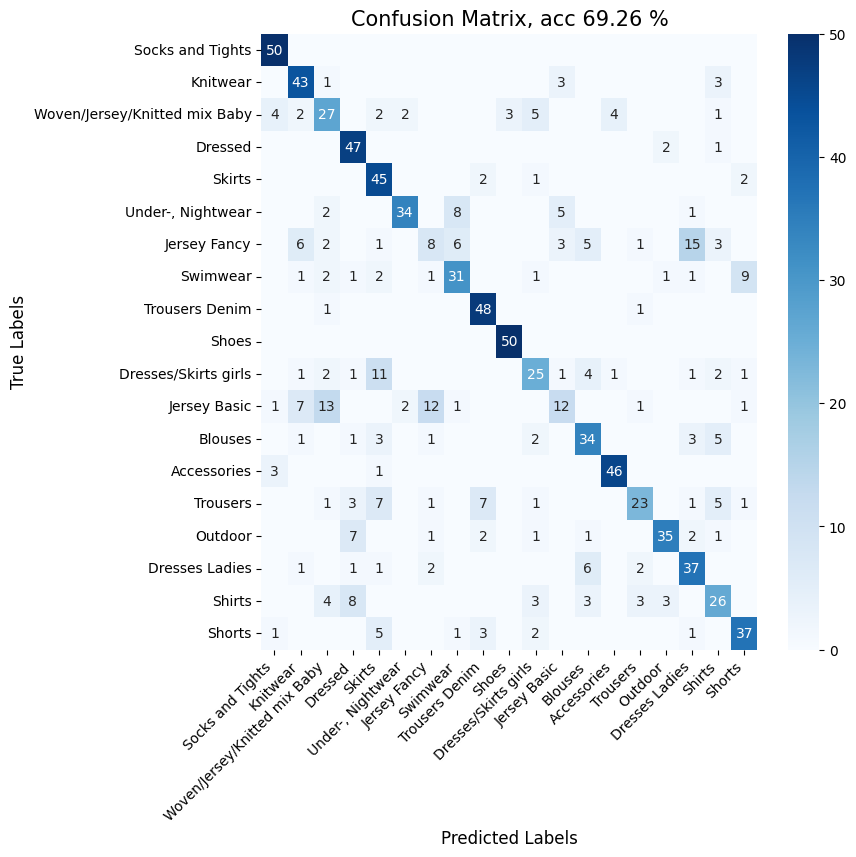

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=0.0001, wd=0.1 is 69.26 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 2359808


 12%|█▏        | 6/50 [00:19<02:19,  3.16s/it]

Patience is 2 / 10


 18%|█▊        | 9/50 [00:28<02:12,  3.22s/it]

Patience is 2 / 10


 20%|██        | 10/50 [00:31<02:07,  3.19s/it]

Patience is 3 / 10


 22%|██▏       | 11/50 [00:35<02:05,  3.21s/it]

Patience is 4 / 10


 24%|██▍       | 12/50 [00:38<02:05,  3.30s/it]

Patience is 5 / 10


 26%|██▌       | 13/50 [00:41<02:01,  3.29s/it]

Patience is 6 / 10


 28%|██▊       | 14/50 [00:45<01:58,  3.28s/it]

Patience is 7 / 10


 30%|███       | 15/50 [00:48<01:55,  3.29s/it]

Patience is 8 / 10


 36%|███▌      | 18/50 [00:58<01:44,  3.26s/it]

Patience is 2 / 10


 42%|████▏     | 21/50 [01:08<01:34,  3.25s/it]

Patience is 2 / 10


 44%|████▍     | 22/50 [01:11<01:31,  3.28s/it]

Patience is 3 / 10


 46%|████▌     | 23/50 [01:14<01:28,  3.26s/it]

Patience is 4 / 10


 52%|█████▏    | 26/50 [01:24<01:18,  3.26s/it]

Patience is 2 / 10


 54%|█████▍    | 27/50 [01:27<01:15,  3.28s/it]

Patience is 3 / 10


 56%|█████▌    | 28/50 [01:30<01:12,  3.29s/it]

Patience is 4 / 10


 58%|█████▊    | 29/50 [01:34<01:08,  3.26s/it]

Patience is 5 / 10


 60%|██████    | 30/50 [01:37<01:05,  3.26s/it]

Patience is 6 / 10


 62%|██████▏   | 31/50 [01:40<01:02,  3.26s/it]

Patience is 7 / 10


 64%|██████▍   | 32/50 [01:43<00:58,  3.26s/it]

Patience is 8 / 10


 66%|██████▌   | 33/50 [01:47<00:55,  3.26s/it]

Patience is 9 / 10


 66%|██████▌   | 33/50 [01:50<00:56,  3.35s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


Accuracyasdasdas 69.78947448730469


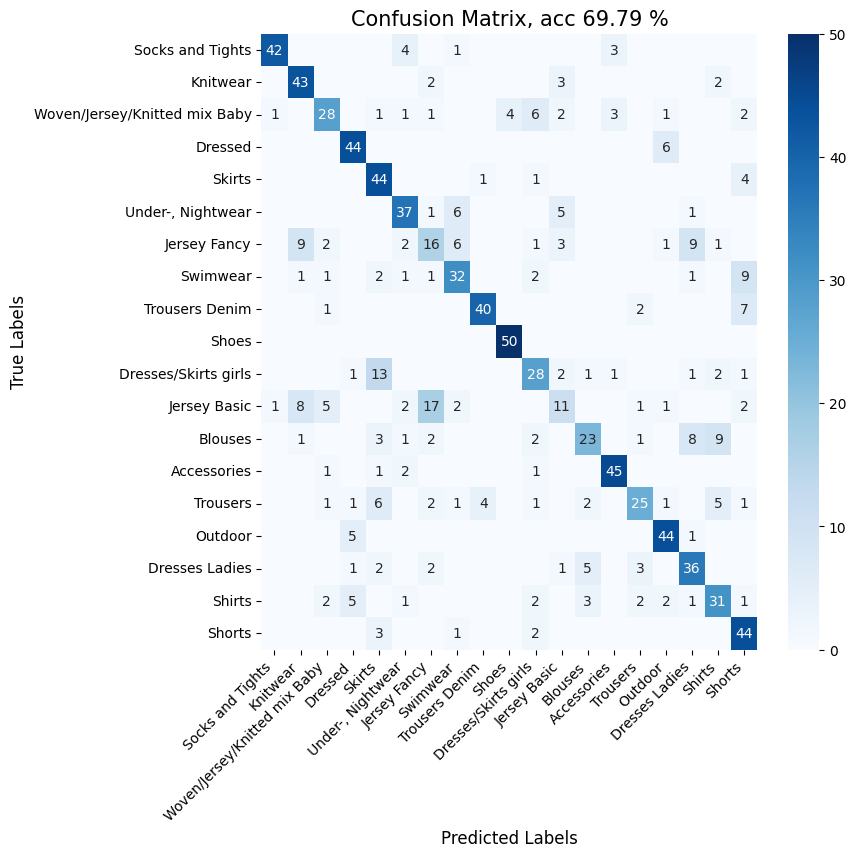

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256] with lr=0.0001, wd=0.0001 is 69.79 %


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Total number of parameters in the optimizer: 1311232


 28%|██▊       | 14/50 [00:39<01:42,  2.86s/it]

Patience is 2 / 10


 34%|███▍      | 17/50 [00:48<01:34,  2.86s/it]

Patience is 2 / 10


 36%|███▌      | 18/50 [00:51<01:31,  2.87s/it]

Patience is 3 / 10


 38%|███▊      | 19/50 [00:54<01:28,  2.85s/it]

Patience is 4 / 10


 40%|████      | 20/50 [00:57<01:25,  2.84s/it]

Patience is 5 / 10


 42%|████▏     | 21/50 [00:59<01:22,  2.83s/it]

Patience is 6 / 10


 44%|████▍     | 22/50 [01:02<01:20,  2.87s/it]

Patience is 7 / 10


 46%|████▌     | 23/50 [01:05<01:17,  2.88s/it]

Patience is 8 / 10


 48%|████▊     | 24/50 [01:08<01:15,  2.89s/it]

Patience is 9 / 10


 48%|████▊     | 24/50 [01:11<01:17,  2.98s/it]


Patience is 10 / 10


100%|██████████| 5/5 [00:00<00:00, 21.73it/s]


Accuracyasdasdas 69.57894897460938


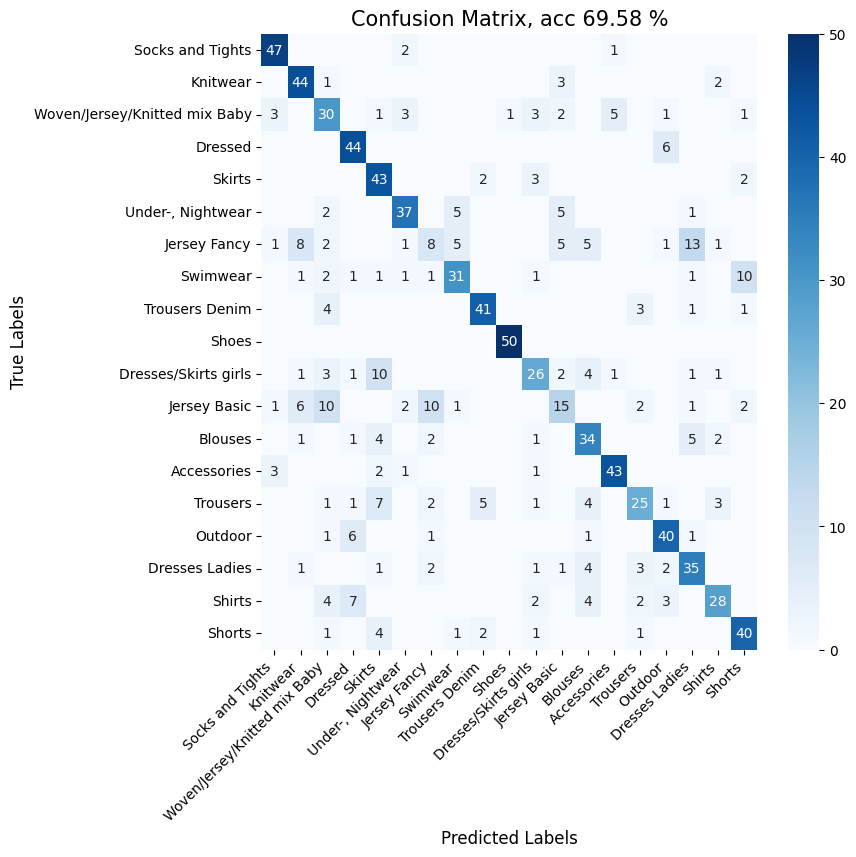

Accuracy for rank configuration [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256] with lr=0.0001, wd=0.0001 is 69.58 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256], Learning Rate: 1e-05, Weight Decay: 0.0, Accuracy: 71.16 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256], Learning Rate: 1e-05, Weight Decay: 0.0, Accuracy: 70.74 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256], Learning Rate: 1e-05, Weight Decay: 0.01, Accuracy: 70.32 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256], Learning Rate: 1e-05, Weight Decay: 0.01, Accuracy: 70.42 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256], Learning Rate: 1e-05, Weight Decay: 0.1, Accuracy: 70.21 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256], Learning Rate: 1e-05, Weight Decay: 0.1, Accuracy: 69.37 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256], Learning Rate: 1e-05, Weight Decay: 0.0001, Accuracy: 69.89 %
Rank configuration: [0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# Initialize the model and processor
import itertools


# Hyperparameter space
learning_rates = [1e-5, 5e-5, 1e-4]
initial_ranks = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 256, 256]
weight_decays = [0.0, 0.01, 0.1 , 0.0001]

results = []

for lr, wd in itertools.product(learning_rates, weight_decays):
    ranks = initial_ranks.copy()
    start = len(ranks) - 3

    for i in range(start, len(ranks) - 1):
        ranks[i] = 0

        if all(rank == 0 for rank in ranks):
            print("All ranks are set to 0. Exiting the loop.")
            break

        model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32", force_download=True).to(device)
        processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", force_download=True)
        processor.feature_extractor.do_rescale = False  # Ensure image values are between [0-1]

        lora_layers = []
        lora_layers = model_functions.apply_lora_to_transformer(model.text_model.encoder.layers, lora_layers, ranks)
        lora_params_attention = model_functions.get_lora_params(model, print_layer=False)

        dataloaders = {'train': dataloader_train, 'val': dataloader_val, 'test': dataloader_test}
        clip = {'m': model, 'p': processor}
        ft = training.FinetuneCLIP(dataloaders, clip, epochs = 50)

        ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 0, 1, 1  # Enable LoRA and Image FC
        ft.initialize({'LoRA': lora_params_attention, 'lr': lr, 'weight_decay': wd})
        ft.count_parameters()

        ft.train()

        all_predictions, all_labels, acc = ft.eval(False)
        utils.confussion_matrix(all_labels, all_predictions, list(dataset_test.class_to_id.keys()), F1=False)
        print(f"Accuracy for rank configuration {ranks} with lr={lr}, wd={wd} is {acc:.2f} %")

        results.append({'ranks': ranks.copy(), 'accuracy': acc, 'lr': lr, 'wd': wd})

for result in results:
    print(f"Rank configuration: {result['ranks']}, Learning Rate: {result['lr']}, Weight Decay: {result['wd']}, Accuracy: {result['accuracy']:.2f} %")

In [8]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32", force_download = True).to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", force_download = True)
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


**LoRA Train with specifc Parameters**

---



In [15]:
ranks = [0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 256]  # Only apply LoRA with rank 64 to the last layer
lr = 1e-05
wd = 0.0001
epochs_num = 200
lora_layers = []

lora_layers = model_functions.apply_lora_to_transformer(model.text_model.encoder.layers , lora_layers, ranks)
lora_params_attention = model_functions.get_lora_params(model, print_layer = True);

# Set up dataloaders and fine-tune process
dataloaders = {'train': dataloader_train, 'val': dataloader_val, 'test': dataloader_test}
clip = {'m': model, 'p': processor}
ft = training.FinetuneCLIP(dataloaders, clip, epochs = epochs_num )

# Initialize LoRA training with current hyperparameters
ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 0, 1 , 0  # Enable LoRA
ft.initialize({'LoRA': lora_params_attention, 'lr': lr, 'weight_decay': wd})
ft.count_parameters()

# Set the optimizer parameters for learning rate and weight decay
#ft.optimizer_params = {'lr': lr, 'weight_decay': wd}  # Ensure your FinetuneCLIP handles this

# Train the model
ft.train()

# Evaluate the model
all_predictions, all_labels, acc = ft.eval(False)
#utils.confussion_matrix(all_labels, all_predictions, list(dataset_test.class_to_id.keys()), F1=False)
ft.plot_loss()

print(f"Accuracy for rank configuration {ranks} with lr={lr}, scale={scale}, wd={wd} is {acc:.2f} %")

text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.k_proj.original_attention_layer.lora_A
text_model.encoder.layers.11.self_attn.k_proj.original_attention_layer.lora_B
text_model.encoder.layers.11.self_attn.k_proj.original_attention_layer.original_attention_layer.lora_A
text_model.encoder.layers.11.self_attn.k_proj.original_attention_layer.original_attention_layer.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.original_attention_layer.lora_A
text_model.encoder.layers.11.self_attn.v_proj.original_attention_layer.lora_B
text_model.encoder.layers.11.self_attn.v_proj.original_attention_layer.original_attention_layer.lora_A
text_model.encoder.layers.11.self_attn.v_proj.original_attention_layer.original_attention_layer.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.

  0%|          | 1/200 [00:04<14:53,  4.49s/it]


KeyboardInterrupt: 

**Train SoftPrompt with Tuned LoRA/CLIP Model**

---



In [ ]:
dataloaders = {'train':dataloader_train, 'val':dataloader_val, 'test':dataloader_test}
clip = {'m':model, 'p':processor}
num_soft = 5
ft = training.FinetuneCLIP(dataloaders, clip)
ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 1, 0 , 1 #soft
ft.initialize({'num_soft':num_soft, 'add':''})
ft.train()

# Evaluate the model
all_predictions, all_labels, acc = ft.eval(False)
#utils.confussion_matrix(all_labels, all_predictions, list(dataset_test.class_to_id.keys()), F1=False)
ft.plot_loss()

print(f"Accuracy  {acc:.2f} %")
